# Animal Classification with 10 Categories

In this project, we use a Convolutional Neural Network (CNN) to classify images of animals into 10 categories. The following libraries are used to load, preprocess the data, build the model, and evaluate its performance:

- **TensorFlow**: For building and training the model.
- **scikit-learn**: For computing metrics like the confusion matrix.
- **Matplotlib & Seaborn**: For data visualization.
- **PIL & IPython**: For image processing and display.

The dataset contains labeled images of 10 animals: butterfly, cat, chicken, cow, dog, elephant, horse, sheep, spider, squirrel.

In [1]:
from IPython.display import display, Image as IPImage
from PIL import Image as PILImage

import os
import random
import numpy as np
from io import BytesIO


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

from ipywidgets import widgets

2024-11-19 13:33:06.517111: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-19 13:33:06.527217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732041186.536420   31528 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732041186.539175   31528 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 13:33:06.550099: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## TensorFlow and GPU Information

This code snippet displays the TensorFlow version, CUDA version, cuDNN version, and the number of GPUs available for TensorFlow.

- The first line prints the TensorFlow version being used.
- The second and third lines retrieve and display the CUDA and cuDNN versions used by TensorFlow.
- The final line shows the number of GPUs available for TensorFlow, helping to confirm whether your system is utilizing the GPU for processing.

This is useful for ensuring that your environment is correctly set up to use GPU acceleration.

In [2]:
print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.18.0


In [3]:
# Get the CUDA version used by TensorFlow
cuda_version = tf.sysconfig.get_build_info()["cuda_version"]
print("CUDA Version:", cuda_version)

# Get the cuDNN version used by TensorFlow
cudnn_version = tf.sysconfig.get_build_info()["cudnn_version"]
print("cuDNN Version:", cudnn_version)

CUDA Version: 12.5.1
cuDNN Version: 9


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Convert Images to JPEG Format

This code converts all images in the dataset to JPEG format to ensure consistency and compatibility.

## Dataset Directory

This code snippet displays the number of images available for each category in the dataset.

- The `DATA_DIR` variable holds the path to the dataset directory.
- A list of categories is defined, representing the different animal classes.
- The loop iterates over each category, counting the number of images in the corresponding subdirectory.
- It prints the number of images found for each category (e.g., "butterfly", "dog", etc.).

This helps in verifying the dataset's structure and ensures each class is well represented in terms of image count.

In [5]:
# Directory that contains the data
DATA_DIR = '/home/juangarzon/projects/computer_vision/datasets/animal_10/images'

# Display the number of images in each class
categories = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
for category in categories:
    data_dir_category = os.path.join(DATA_DIR, category)
    print(f"There are {len(os.listdir(data_dir_category))} images of {category.lower()}s.")

There are 2112 images of butterflys.
There are 1668 images of cats.
There are 3098 images of chickens.
There are 1866 images of cows.
There are 4863 images of dogs.
There are 1446 images of elephants.
There are 2623 images of horses.
There are 1820 images of sheeps.
There are 4822 images of spiders.
There are 1862 images of squirrels.


This code snippet visualizes sample images from each category in the dataset.

- A 2x5 grid of subplots is created using `plt.subplots()`, where the figure size is set to 20x8 inches.
- The title of the figure is set to 'Sample Images from Each Category'.
- The loop iterates through the first 10 categories and loads the first image from each category.
- Each image is displayed in its respective subplot, with the title indicating the category name.

This allows a quick preview of the dataset, showing sample images from each class to verify the quality and diversity of the data.

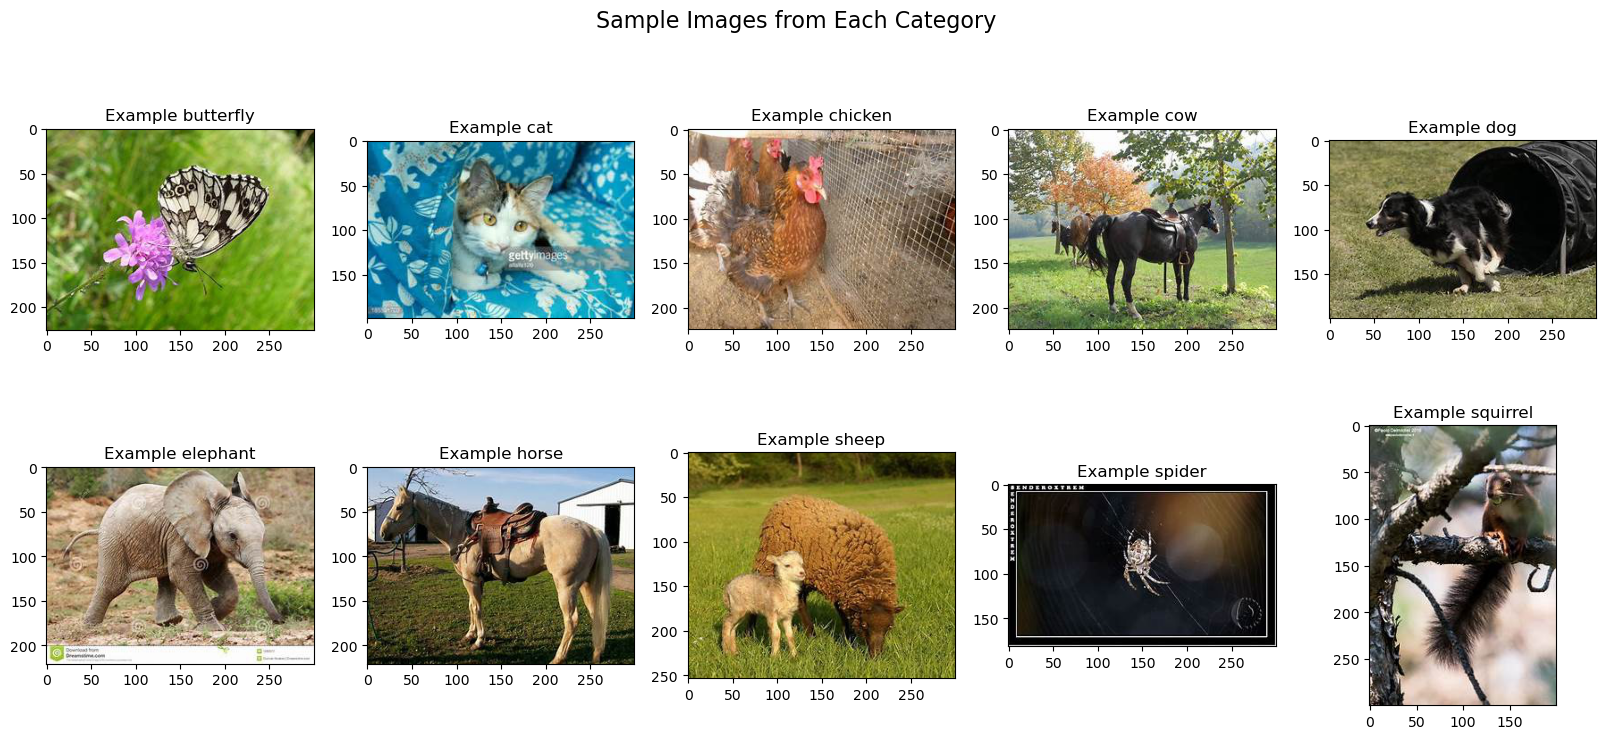

In [6]:
# Create the figure and axes
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Sample Images from Each Category', fontsize=16)

# Display one image from each category
for i, category in enumerate(categories[:10]):
    # Path of the first image from each category
    category_files = os.listdir(os.path.join(DATA_DIR, category))
    img_path = os.path.join(DATA_DIR, category, category_files[0])
    img = PILImage.open(img_path)
    
    # Show the image with visible axes
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].set_title(f'Example {category}')

# Show the figure
plt.show()

## Load and Split Dataset

This function loads the dataset from the specified directory, resizes the images to 224x224, and splits the data into training and validation sets (85% training, 15% validation).

In [7]:
def train_val_datasets():
    # Load the dataset and split it into training and validation sets
    training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=DATA_DIR,
        image_size=(224, 224),  # Resize all images to 224x224
        batch_size=32,  # Set the batch size to 32
        label_mode='int',  # 'int' for multiclass classification (10 categories)
        validation_split=0.15,  # 15% of the data will be used for validation
        subset='both',  # Load both training and validation subsets
        seed=42  # Set a seed for reproducibility
    )

    return training_dataset, validation_dataset

training_dataset, validation_dataset = train_val_datasets() 

Found 26180 files belonging to 10 classes.
Using 22253 files for training.
Using 3927 files for validation.


I0000 00:00:1732041188.860223   31528 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13512 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9


In [8]:
print("Categories detected:", training_dataset.class_names)

Categories detected: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [9]:
print(f"Number of batches in training dataset: {len(training_dataset)}")
print(f"Number of batches in validation dataset: {len(validation_dataset)}")

Number of batches in training dataset: 696
Number of batches in validation dataset: 123


## Calculate Class Weights

This code calculates the class weights to address class imbalance in the training dataset. The weights are based on the distribution of labels and ensure that underrepresented classes have more influence during training.

In [10]:
# Calculate class weights based on the distribution in the training set
def calculate_class_weights(training_dataset):
    # Get the labels of the training dataset
    class_labels = []
    for image_batch, label_batch in training_dataset:
        class_labels.extend(label_batch.numpy())

    # Calculate the class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)
    class_weight_dict = dict(zip(np.unique(class_labels), class_weights))
    return class_weight_dict

# Calculate class weights
class_weights = calculate_class_weights(training_dataset)

# Show the class weights
print("Class weights:", class_weights)

Class weights: {0: 1.241796875, 1: 1.5496518105849582, 2: 0.844516129032258, 3: 1.4013224181360202, 4: 0.5372525350072429, 5: 1.7845228548516439, 6: 0.9978923766816143, 7: 1.4301413881748073, 8: 0.549864096861873, 9: 1.4084177215189873}


2024-11-19 13:33:11.579668: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Inspect First Batch of Training Data

This code retrieves the first batch of images and labels from the training dataset to check their shapes and the maximum pixel value, providing an overview of the data structure and pixel range.

In [11]:
# Get the first batch of images and labels
for images, labels in training_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels

print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

Maximum pixel value of images: 255.0

Shape of batch of images: (32, 224, 224, 3)
Shape of batch of labels: (32,)


2024-11-19 13:33:11.601771: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Data Augmentation Model

This function creates a data augmentation model using TensorFlow's Sequential API. It applies random transformations like flipping, rotation, translation, and zooming to enhance the diversity of training data and improve the model's generalization.

In [12]:
def create_augmentation_model():
    # Create a sequential model for applying data augmentations
    # The augmentations include random flips, rotations, translations, and zooms
    FILL_MODE = 'nearest'  # Fill mode to handle empty spaces during augmentation
    
    augmentation_model = tf.keras.Sequential([ 
        tf.keras.Input(shape=(224, 224, 3)),  # Input shape of the images
        tf.keras.layers.RandomFlip("horizontal"),  # Randomly flip images horizontally
        tf.keras.layers.RandomRotation(0.1, fill_mode=FILL_MODE),  # Random rotation up to 10%
        tf.keras.layers.RandomTranslation(0.1, 0.1, fill_mode=FILL_MODE),  # Random translation by 10% width/height
        tf.keras.layers.RandomZoom(0.1, fill_mode=FILL_MODE)  # Random zoom up to 10%
    ]) 
    
    return augmentation_model

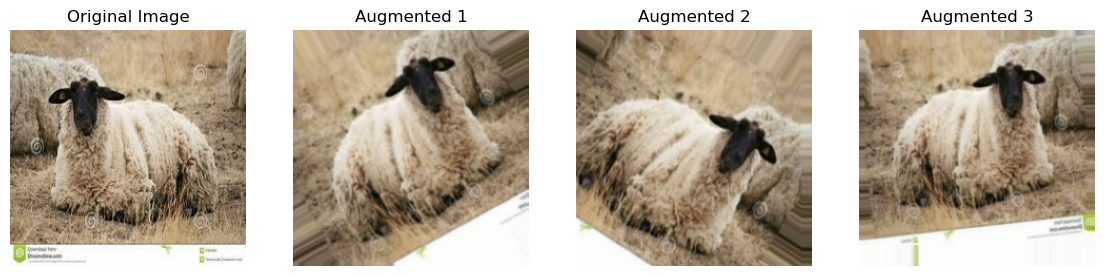

In [13]:
# Load your model for augmentation
data_augmentor = create_augmentation_model()

# Take a sample image
sample_image = tf.keras.utils.array_to_img(example_batch_images[0])

images = [sample_image]

# Apply random augmentation 3 times
for _ in range(3):
	image_aug = data_augmentor(tf.expand_dims(sample_image, axis=0))
	image_aug = tf.keras.utils.array_to_img(tf.squeeze(image_aug))
	images.append(image_aug)


fig, axs = plt.subplots(1, 4, figsize=(14, 7))
for ax, image, title in zip(axs, images, ['Original Image', 'Augmented 1', 'Augmented 2', 'Augmented 3']):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.show()

## Model Creation Process

This code defines a Convolutional Neural Network (CNN) for image classification. The model consists of multiple convolutional layers to extract features from the images, followed by pooling layers to reduce the dimensionality. The output is flattened and passed through fully connected layers, with regularization techniques like Dropout and L2 regularization to prevent overfitting. Finally, the model is compiled with the Adam optimizer and sparse categorical cross-entropy loss function, and trained on a dataset to classify images into different categories.

In [14]:
def create_model():
    # Create a CNN model for classifying 10 animal categories
    # The model includes data augmentation, convolutional blocks, and a classifier

    # Augmentation layer (or model) from your earlier function
    augmentation_layers = create_augmentation_model()

    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(224, 224, 3)),  # Define the input shape for the model
        augmentation_layers,  # Apply data augmentation layers
        tf.keras.layers.Rescaling(1./255),  # Normalize pixel values to the range [0, 1]

        # Block 1: Convolution, Batch Normalization, Max Pooling
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=regularizers.l2(0.002)),  # Convolutional layer with L2 regularization
        tf.keras.layers.BatchNormalization(),  # Normalize activations for stability
        tf.keras.layers.MaxPooling2D((2, 2)),  # Downsample feature maps

        # Block 2: Convolution, Batch Normalization, Max Pooling
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=regularizers.l2(0.002)),  # Second convolutional layer
        tf.keras.layers.BatchNormalization(),  # Normalize activations
        tf.keras.layers.MaxPooling2D((2, 2)),  # Downsample again

        # Block 3: Convolution, Batch Normalization, Max Pooling
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=regularizers.l2(0.002)),  # Third convolutional layer
        tf.keras.layers.BatchNormalization(),  # Normalize activations
        tf.keras.layers.MaxPooling2D((2, 2)),  # Downsample further

        # Block 4: Convolution, Batch Normalization, Max Pooling
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=regularizers.l2(0.002)),  # Fourth convolutional layer
        tf.keras.layers.BatchNormalization(),  # Normalize activations
        tf.keras.layers.MaxPooling2D((2, 2)),  # Final downsample layer

        # Block 5: Convolution, Batch Normalization, Max Pooling
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=regularizers.l2(0.002)),  # Fourth convolutional layer
        tf.keras.layers.BatchNormalization(),  # Normalize activations
        tf.keras.layers.MaxPooling2D((2, 2)),  # Final downsample layer

        # Classifier: Fully connected layers for final prediction
        tf.keras.layers.Flatten(),  # Flatten the 2D feature maps into a 1D vector
        tf.keras.layers.Dropout(0.6),  # Dropout to prevent overfitting
        tf.keras.layers.Dense(256, activation='relu'),  # Fully connected layer
        tf.keras.layers.BatchNormalization(),  # Normalize activations
        tf.keras.layers.Dense(10, activation='softmax')  # Output layer with softmax activation for 10 classes
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)  # Optimizer with a defined learning rate
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Compile the model with loss and metrics
    
    return model  

model = create_model()

In [15]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,57

 Total params: 7,998,922 (30.51 MB)

 Trainable params: 7,996,426 (30.50 MB)

 Non-trainable params: 2,496 (9.75 KB)

## Callbacks Explanation

- **EarlyStopping**: This callback monitors the validation loss (`val_loss`) during training. If the validation loss does not improve for a specified number of epochs (`patience=10`), it stops the training early and restores the model's weights from the epoch with the best validation loss to avoid overfitting.

- **ReduceLROnPlateau**: This callback monitors the validation loss (`val_loss`). If the validation loss plateaus (i.e., doesn't improve) for a certain number of epochs (`patience=5`), it reduces the learning rate by a factor of 0.5 to help the model escape local minima and continue improving. The learning rate will not go below a minimum value (`min_lr=1e-6`).

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

## Model Training Explanation

- **`model.fit`**: This function trains the model using the specified dataset. It runs for a maximum of 100 epochs (`epochs=100`), but the training may stop early based on the `EarlyStopping` callback. 
- **`training_dataset`**: The dataset used for training the model.
- **`validation_dataset`**: The dataset used for validating the model's performance during training.
- **`callbacks`**: Includes the `early_stopping` and `reduce_lr` callbacks, which help prevent overfitting and adjust the learning rate dynamically.
- **`class_weight`**: Adjusts the weights of the classes to handle imbalanced datasets, assigning higher weights to underrepresented classes during training.

In [17]:
history = model.fit(
	training_dataset,
	epochs=100,
	validation_data=validation_dataset,
	callbacks = [early_stopping, reduce_lr],
    class_weight=class_weights
)

Epoch 1/100


I0000 00:00:1732041194.832879   31623 cuda_dnn.cc:529] Loaded cuDNN version 90300


696/696 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - accuracy: 0.3208 - loss: 3.2989 - val_accuracy: 0.4500 - val_loss: 2.5574 - learning_rate: 5.0000e-04
Epoch 2/100
696/696 ━━━━━━━━━━━━━━━━━━━━ 35s 51ms/step - accuracy: 0.4906 - loss: 2.2552 - val_accuracy: 0.3970 - val_loss: 2.5721 - learning_rate: 5.0000e-04
Epoch 3/100
696/696 ━━━━━━━━━━━━━━━━━━━━ 35s 51ms/step - accuracy: 0.5644 - loss: 1.7745 - val_accuracy: 0.4110 - val_loss: 2.1989 - learning_rate: 5.0000e-04
Epoch 4/100
696/696 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.6113 - loss: 1.5502 - val_accuracy: 0.5174 - val_loss: 1.9814 - learning_rate: 5.0000e-04
Epoch 5/100
696/696 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step - accuracy: 0.6419 - loss: 1.4627 - val_accuracy: 0.5671 - val_loss: 1.7476 - learning_rate: 5.0000e-04
Epoch 6/100
696/696 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.6666 - loss: 1.4158 - val_accuracy: 0.6313 - val_loss: 1.5843 - learning_rate: 5.0000e-04
Epoch 7/100
696/696 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - a

## Training and Validation Performance Visualization

This code generates a plot to visualize the model's performance during training. It shows how accuracy and loss change for both the training and validation datasets over the epochs. Two subplots are used: one for accuracy and another for loss. This helps evaluate whether the model is improving and if it's overfitting or underfitting during the training process.

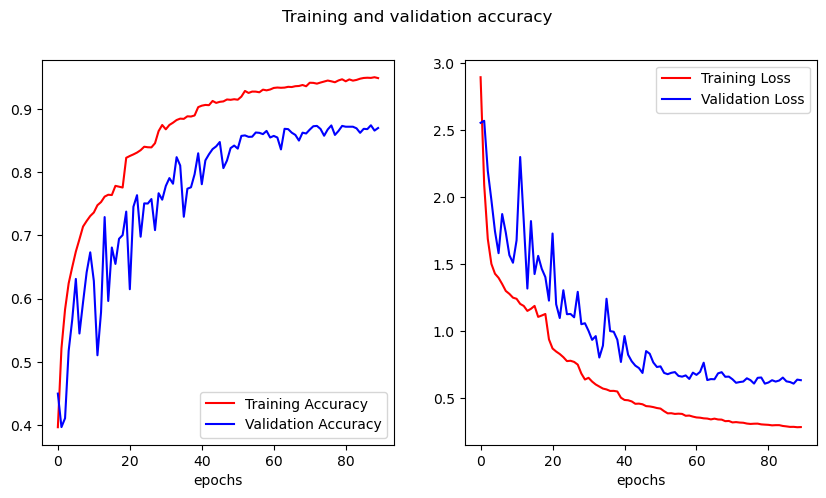

In [24]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

## Saving the Model

This code saves the trained model, including its architecture, weights, and optimizer state, to a file. The model is stored in HDF5 format with the filename 'animal_10.h5'. This format is widely used for model portability and allows you to reload the model later for inference or further training without needing to redefine its structure.

In [25]:
# Save the complete model (architecture, weights, optimizer) to a file
model.save('animal_10.h5')  # Save as HDF5 format (useful for portability)

print("Model saved successfully.")

Model saved successfully.


## Loading the Model

In [26]:
# Load the saved model
loaded_model = tf.keras.models.load_model('animal_10.h5')

print("Model loaded successfully.")

# Compile the model manually if you need to avoid the warning (optional)
# loaded_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model loaded successfully.


## Generating and Visualizing the Confusion Matrix

This code generates a confusion matrix to evaluate the performance of the model by comparing the true labels (`y_true`) with the predicted labels (`y_pred`). The confusion matrix is then visualized as a heatmap using Seaborn, with a red colormap to highlight the results. The matrix's axes are labeled with the categories of the classification, and the values are annotated to show the number of correct and incorrect predictions for each class. The title of the matrix is set to 'Confusion Matrix'.

In [27]:
# Function to get predictions from the model
def get_predictions(model, dataset):
    y_true = []  # List to store true labels
    y_pred = []  # List to store predicted labels

    # Iterate over the validation dataset
    for images, labels in dataset:
        # Get the model's predictions
        pred = model.predict(images)
        y_true.extend(labels.numpy())  # True labels
        y_pred.extend(np.argmax(pred, axis=1))  # Predicted labels (argmax to get the class)

    return np.array(y_true), np.array(y_pred)

# Load training and validation datasets
training_dataset, validation_dataset = train_val_datasets()

# Get the true and predicted labels
y_true, y_pred = get_predictions(model, validation_dataset)

Found 26180 files belonging to 10 classes.
Using 22253 files for training.
Using 3927 files for validation.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━

2024-11-19 14:32:07.324978: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


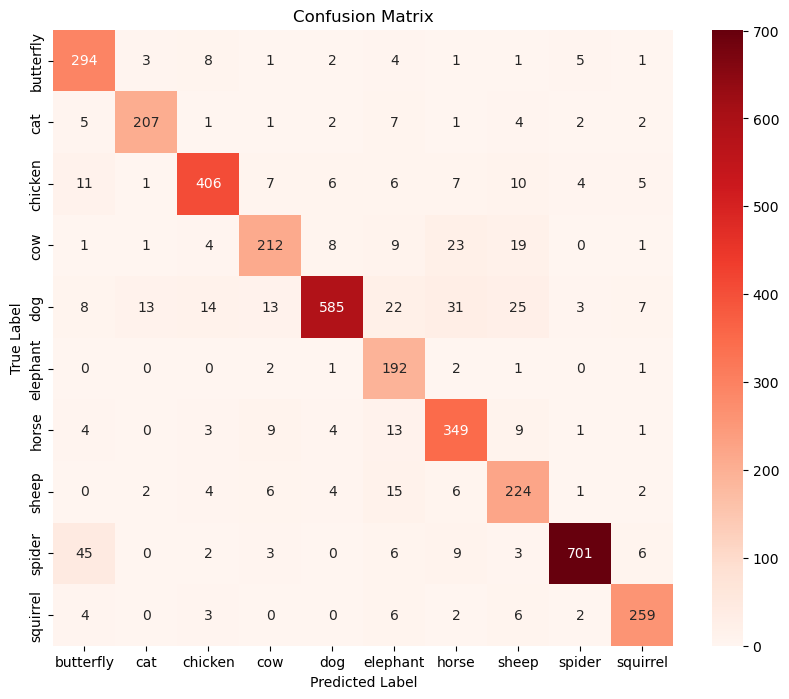

In [28]:
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix using a heatmap with a red colormap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=categories, yticklabels=categories)
plt.ylabel('True Label')  # Label for the y-axis
plt.xlabel('Predicted Label')  # Label for the x-axis
plt.title('Confusion Matrix')  # Title of the matrix
plt.show()

## Image Prediction with File Upload Widget

This code provides a method for predicting the class of uploaded images using a pre-trained model. The process includes:

1. **File Upload**: A widget is used to upload image files. The widget accepts only image files (`accept="image/*"`).
2. **Image Processing**:
   - The uploaded image is resized to 224x224 pixels, matching the input size expected by the model.
   - The image is displayed in the output widget after resizing.
   - The image is then converted into an array, with an additional batch dimension added to prepare it for model prediction.
3. **Model Prediction**:
   - The model makes a prediction for the uploaded image.
   - The predicted class is determined by finding the index of the highest probability in the model's output.
4. **Output**: The result is displayed with the predicted class name and the uploaded file name.

This process allows for easy testing and visualization of predictions for multiple image uploads in real time using an interactive widget interface.

In [23]:
def file_predict(filename, file, out):
    """ A function for creating the prediction and displaying the output. """
    # Load the image and display it
    img = PILImage.open(file)  # Use PIL to open the image file
    img_resized = img.resize((224, 224))  # Resize the image to match the model input size
    
    # Display the image
    img_byte_arr = BytesIO()
    img_resized.save(img_byte_arr, format='PNG')  # Save the resized image to the byte array
    img_byte_arr = img_byte_arr.getvalue()  # Get the byte content
    
    with out:
        out.clear_output()
        display(IPImage(data=img_byte_arr))  # Display the resized image
    
    # Convert the image to array and add the batch dimension
    image_array = tf.keras.utils.img_to_array(img_resized)
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    
    # Make the prediction
    prediction = loaded_model.predict(image_array, verbose=0)[0]  # Model output for all classes
    
    # Get the index of the highest probability
    predicted_class_index = np.argmax(prediction)
    
    # Get the corresponding category
    predicted_class = categories[predicted_class_index]
    
    # Print the prediction result
    with out:
        print(f"{filename} is a {predicted_class}")

# Create the widget for file upload
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)

# Create the output display
out = widgets.Output()
display(out)

def on_upload_change(change):
    """ A function for getting files from the widget and running the prediction. """
    # Get the newly uploaded file(s)
    items = change.new
    for item in items:  # Loop if there is more than one file uploaded  
        file_jpgdata = BytesIO(item.content)  # Convert the file content into a BytesIO object
        file_predict(item.name, file_jpgdata, out)  # Run the prediction

# Attach the observer to the uploader widget
uploader.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()